In [1]:
import os

from dotenv import load_dotenv
from huggingface_hub import login

load_dotenv()
token = os.getenv('HF_TOKEN')
login(token=token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments

import torch
from transformers import pipeline

# Configuração do Matplotlib e Seaborn
%matplotlib inline
sns.set_theme(style='whitegrid')


In [20]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("stanfordnlp/sentiment140", trust_remote_code=True)
# ds = load_dataset("PrkhrAwsti/Twitter_Sentiment_3M")

print(dataset)
# Converter para DataFrame Pandas
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])


Generating train split:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/498 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'date', 'user', 'sentiment', 'query'],
        num_rows: 1600000
    })
    test: Dataset({
        features: ['text', 'date', 'user', 'sentiment', 'query'],
        num_rows: 498
    })
})


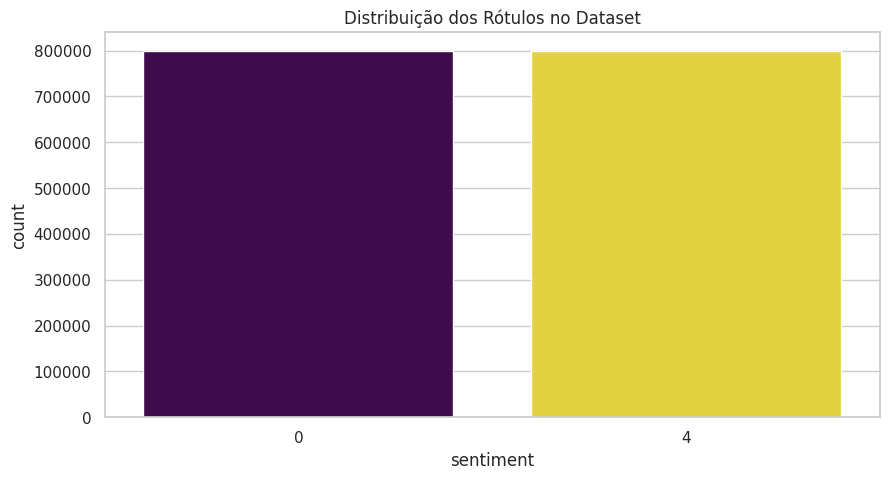

In [22]:


# Visualizando a distribuição dos rótulos (hate speech vs non-hate speech)
plt.figure(figsize=(10, 5))
sns.countplot(x='sentiment', data=df_train, palette='viridis', hue='sentiment', legend=False)
plt.title('Distribuição dos Rótulos no Dataset')
plt.show()

In [23]:
# sentiment_pipeline = pipeline("sentiment-analysis")
# df['sentiment'] = df['tweet'].apply(lambda x: sentiment_pipeline(x)[0]['label'])
# Carregar o tokenizador BERT
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained('macildur/distilbert-base-uncasedv1-finetuned-twitter-sentiment')

# tokenizer = AutoTokenizer.from_pretrained("macildur/distilbert-base-uncasedv1-finetuned-twitter-sentiment")
# Tokenizing the text data
def tokenize_text(text):
    return tokenizer(text, padding='max_length', truncation=True, return_tensors='pt')
tokenized_datasets = {}
# Applying the tokenizer to the 'text' column
tokenized_datasets['train'] = dataset['train'].map(
    lambda x: tokenizer(x['text'], padding='max_length', truncation=True),
    batched=True
)
tokenized_datasets['test'] = dataset['test'].map(
    lambda x: tokenizer(x['text'], padding='max_length', truncation=True),
    batched=True
)
# Load model directly

model = DistilBertForSequenceClassification.from_pretrained("macildur/distilbert-base-uncasedv1-finetuned-twitter-sentiment", num_labels=2)


Map:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Map:   0%|          | 0/498 [00:00<?, ? examples/s]

In [26]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
print(torch.cuda.is_available())  # Should return True if GPU is available
print(torch.cuda.current_device())  # Should return the current device id
print(torch.cuda.get_device_name(0))  # Should return the name of the GPU
print(torch.backends.cudnn.version())

# Definir argumentos de treinamento
training_args = TrainingArguments(
    output_dir='./results',          # Pasta de saída
    eval_strategy="epoch",     # Avaliar a cada época
    learning_rate=2e-5,              # Taxa de aprendizado
    per_device_train_batch_size=4,  # Tamanho do lote de treinamento
    per_device_eval_batch_size=4,   # Tamanho do lote de avaliação
    num_train_epochs=1,              # Número de épocas de treinamento
    weight_decay=0.01,               # Decaimento do peso
    logging_dir='./logs',  # Directory for storing logs

    # fp16=True,
    # load_best_model_at_end = True
)

# Definir o treinador
trainer = Trainer(
    model=model,                         # O modelo a ser treinado
    args=training_args,                  # Argumentos de treinamento
    train_dataset=tokenized_datasets['train'],  # Dataset de treinamento
    eval_dataset=tokenized_datasets['test'],    # Dataset de avaliação
    # compute_metrics=
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)
# Evaluate the model
eval_result = trainer.evaluate()

# Predictions and metrics calculation
predictions, label_ids, _ = trainer.predict(tokenized_datasets['test'])
predictions = torch.argmax(torch.tensor(predictions), dim=1)  # Get the predicted classes

# Calculate metrics
accuracy = accuracy_score(label_ids, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(label_ids, predictions, average='weighted')

# Print metrics
print(f"Avaliação do Modelo: {eval_result}")
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão (precision): {precision:.2f}")
print(f"Revocação (recall): {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

True
0
NVIDIA GeForce RTX 3060 Laptop GPU
90100


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
